In [109]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8) # set default size of plots

In [110]:
import numpy as np

In [111]:
from keras.datasets import cifar10
from random import randrange
import time

# Полносвязная нейронная сеть
В данном домашнем задании вы подготовите свою реализацию двухслойной полносвязной нейронной сети и обучите классификатор на датасете CIFAR-10. Вы можете использовать любую из известных вам функций активации для скрытого слоя, а в качестве функции потерь  используйте cross entropy loss (его ещё иногда называют softmax loss)

Даже такая простая искуственная нейронная сеть структурно значительно сложнее, чем SVM. Организуем код в виде класса, нечто подобное используется во фреймворке Pytorch. При выполнении задания приветствуется создание новых приватных методов в классе, описывающем сеть.

In [318]:
class TwoLayerNet(object):  
    # В конструкторе зададим все веса, которые нам понадобятся
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        W1: Первый слой с размерами (D, H)
        b1: Вектор сдвигов, размер  (H,)
        W2: Второй слой с размерами (H, C)
        b2: Вектор сдвигов, размер (C,)

        Входные парамерты:
        - input_size: Размерность входных данных
        - hidden_size: Размер скрытого слоя
        - output_size: Количество классов
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
                
    def f_active(self,X):
        """
        X - size of N,H (train size and hidden size)
        """
        X[X<0] = 0
        self.X_pos = np.copy(X)
        return X

    def grad_f_active(self):  # N,H
        grad = self.X_pos
        grad[grad>0] = 1
        return grad
    
    def loss(self, X, y=None, reg=0.0, verbose = False):
        """
        Вычисление функции потерь

        Входные парамерты:
        - X: Таблица данных (N, D). X[i] - один пример
        - y: Вектор лейблов. Если отсутсвует, то возвращается предсказание лейблов
        - reg: Коэффициент регуляризации

        Возвращает:
        Если y == None, то возвращаются оценка (score) для классов

        Если y != None, то возвращаются:
        - Значение функции потерь для данного семпла данных
        - grads: Словарь градиентов, ключи соответствуют ключам словаря self.params.
        """
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape
        
        eps = 0.00000001
        
        # Расчет forward pass или прямой проход, для данных находятся оценки (scores),  
        # Выходная размерность (N, C), количество объектов на количество классов
        # Впишите свой код на место заглушки
        
        scores = None
        scores_h = np.dot(X,W1) + b1
        scores_active = self.f_active(scores_h)  ## (N, H)
        scores = np.dot(scores_active,W2) + b2
        
        if verbose: print ("scores: ",scores)
        
        # Если y == None, то завершаем вызов
        if y is None:
            return scores

        loss = None
        # Расчет cross entropy loss, на выходе должен получиться скаляр    
        # Впишите свой код на место заглушки
        
        row_arg_max = np.argmax(scores,axis=1)
        ss1 = scores   - np.reshape(scores[range(X.shape[0]),row_arg_max],[X.shape[0],1])
        ss1 = np.exp(ss1)
        ss_probs = ss1 / np.reshape(np.sum(ss1,axis=1),(X.shape[0],1))
        ss_probs_log = np.log(eps+ss_probs[range(X.shape[0]),y])
        loss = - 1/X.shape[0] *np.sum(ss_probs_log)
        
        loss = loss + reg * (np.sum(b1*b1) + np.sum(b2*b2) + np.sum(W1*W1)+ np.sum(W2*W2))
                
        grads = {}
        # Расчет обратнохо прохода или backward pass, находятся градиенты для всех параметров, 
        # результаты сохраняются в grads, например grads['W1']
        # Впишите свой код на место заглушки
        
        grads['W1'] = np.zeros(W1.shape)
        grads['b1'] = np.zeros(b1.shape)
        grads['W2'] = np.zeros(W2.shape)
        grads['b2'] = np.zeros(b2.shape)
        
        probs_true = ss_probs[range(X.shape[0]),y]
        probs_true = np.reshape(probs_true,[probs_true.shape[0],1])
        if verbose: print ("probs true: ", probs_true)
        
        ## prob_true * I(i==true) - prob_true * p_i
        ##
        dce_dsm = - 1/X.shape[0] * 1/(eps+probs_true)
        dce_dsm = dce_dsm
        if verbose: print ("d_ce: ", dce_dsm)
        
        dsm_df = (-1) * ss_probs * probs_true
        dsm_df[range(dsm_df.shape[0]),y] += np.reshape(probs_true,[probs_true.shape[0]])
        if verbose: print ("d_sm: ", dsm_df)
        
        dsm_df = dsm_df * dce_dsm  ## (N * C)
        grads['b2'] = np.sum(dsm_df,axis=0) + 2 * reg * b2
        if verbose: print ("grad_b2: ",grads['b2'] )
        grads['W2'] = np.dot(scores_active.T,dsm_df)   + 2 * reg * W2 ## H * C

        grad_active = np.dot(dsm_df,W2.T) * self.grad_f_active()
        grads['b1'] = np.sum(grad_active,axis=0) + 2 * reg * b1
        grads['W1'] = np.dot(X.T,grad_active) + 2 * reg * W1
        
        return loss, grads
    

    def train(self, X, y, X_val, y_val,
                learning_rate=1e-3, learning_rate_decay=0.95,
                reg=5e-6, num_iters=100,
                batch_size=200, verbose=False):
        """
        Обучение нейронной сети с помощью SGD

        Входные парамерты:
        - X: Матрица данных (N, D)
        - y: Вектор лейблов (N, )
        - X_val: Данные для валидации (N_val, D)
        - y_val: Вектор лейблов валидации (N_val, )
        - reg: Коэффициент регуляризации
        - num_iters: Количнство итераций
        - batch_size: Размер семпла данных, на 1 шаг алгоритма
        - verbose: Вывод прогресса
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # Выбираем минибатч из выборки и заполняем X_batch и y_batch
            # Впишите свой код на место заглушки
            idx = np.random.choice(range(X.shape[0]),batch_size)
            X_batch = X[idx]
            y_batch = y[idx]
            
#             print (X_batch.shape)
#             print(y_batch.shape)
            
            # Производим рассчёт значения функции потерь и градиентов
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            # Используя градиенты из grads обновите параметры сети. 
            # Hint: ключи в словарях градиентов и параметров должны совпадать, можно по ним проитерировать
            # Впишите свой код на место заглушки
            for i_key in grads.keys():
                self.params[i_key] -= learning_rate * grads[i_key]
#             
            
            if verbose and it % 100 == 0:
                print(f'iteration {it}/{num_iters}: loss {loss:.4f}')
                
            if it % iterations_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)
                
                # Уменьшаем learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Входные параметры:
        - X: Матрица данных (N, D)

        Возвращает:
        - y_pred: Вектор предсказаний классов для обьектов (N,)
        """
        y_pred = None

        # Предсказание классов для обьектов из X     
        # Впишите свой код на место заглушки
        y_proba = self.loss(X)
        y_pred = np.argmax(y_proba, axis =1)
        
        return y_pred

In [319]:
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X_toy, y_toy = init_toy_data()
    
    
_, _ = net.loss(X_toy,y_toy,verbose=False)

# Тестируем написанный код

Ниже приведена функция, осуществляющая численную проверку градиента.

In [320]:
def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y)))) 

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    
    fx = f(x)
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h 
        fxph = f(x) 
        x[ix] = oldval - h
        fxmh = f(x) 
        x[ix] = oldval 

        # Вычисляем частную производную
        grad[ix] = (fxph - fxmh) / (2 * h) 
        if verbose:
            print(ix, grad[ix])
        it.iternext() 

    return grad

Сгенерируем простые данные и выполним тест.

In [321]:
input_size = 4  ## vector size
hidden_size = 10
num_classes = 3
num_inputs = 5  ## batch size

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X_toy, y_toy = init_toy_data()

loss, grads = net.loss(X_toy, y_toy, verbose=False)


In [322]:
loss, grads = net.loss(X_toy, y_toy, reg=0.0)

# Ошибка должна быть меньше или около 1e-8
for param_name in grads:
    f = lambda _: net.loss(X_toy, y_toy, reg=0.0)[0] # функция не использует аргумент, это нормально :)
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 5.172564e-09
b1 max relative error: 1.501249e-09
W2 max relative error: 5.067659e-10
b2 max relative error: 8.461108e-11


In [323]:
loss, grads = net.loss(X_toy, y_toy, reg=0.05)

# Ошибка должна быть меньше или около 1e-8
for param_name in grads:
    f = lambda _: net.loss(X_toy, y_toy, reg=0.05)[0] # функция не использует аргумент, это нормально :)
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.561318e-09
b1 max relative error: 1.501249e-09
W2 max relative error: 3.440708e-09
b2 max relative error: 8.461108e-11


Реализуйте метод `TwoLayerNet.train` и метод `TwoLayerNet.predict`

Обучите сеть на игрушечных данных, которые мы сгенерировали выше, значение функции потерь дольжно быть меньше или около $0.2$.

Final training loss:  0.015166876303082446


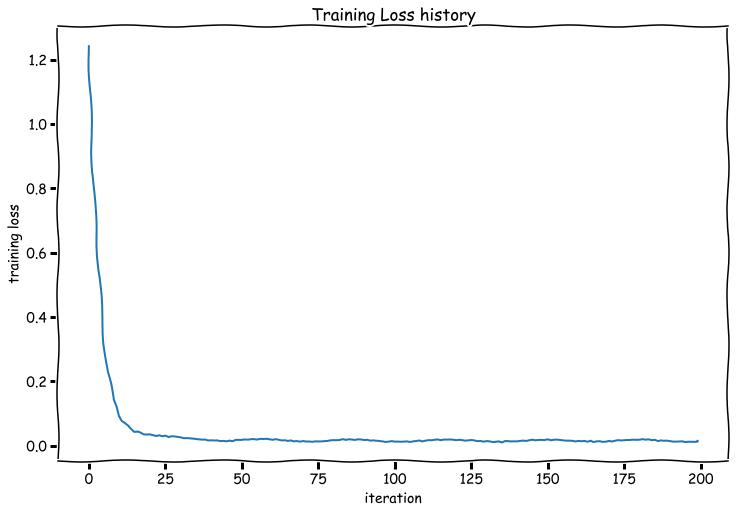

In [324]:
net = init_toy_model()
stats = net.train(X_toy, y_toy, X_toy, y_toy,
            learning_rate=1e-1, reg=5e-6,
            num_iters=200, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])
with plt.xkcd():
    plt.plot(stats['loss_history'])
    plt.xlabel('iteration')
    plt.ylabel('training loss')
    plt.title('Training Loss history')
    plt.show()

# Обучение сети
Теперь, когда всё готово, вы можете обучить сеть на данных CIFAR-10

In [406]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

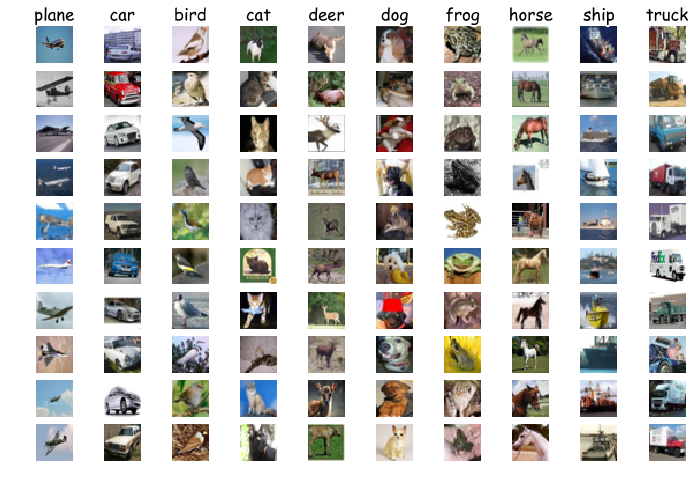

In [407]:
with plt.xkcd():
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_classes = len(classes)
    samples_per_class = 10
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(x_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

In [408]:
# Preprocessing: преобразуем изображения к плоскому виду
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
y_train = np.squeeze(y_train, 1)
y_test = np.squeeze(y_test, 1)


# Печатаем размерности, чтобы проверить что мы не ошиблись
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


[130.71074 136.05614 132.5538  130.14036 135.44238 131.85358 131.05044
 136.24616 132.58144 131.56886]


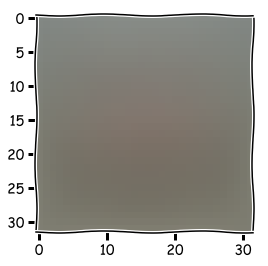

In [409]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10]) # для проверки напечаем несколько элементов
with plt.xkcd():
    plt.figure(figsize=(4,4))
    plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
    plt.show()
    
    

In [410]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [413]:
np.mean(x_test, axis=0)

array([-0.17534, -0.00994,  0.2762 , ..., -0.09078,  0.1523 ,  0.94524])

In [415]:
n_samples = x_train.shape[0]
x_val, y_val = x_train[:int(n_samples*0.05)], y_train[:int(n_samples*0.05)]
x_train, y_train = x_train[int(n_samples*0.05):], y_train[int(n_samples*0.05):]

In [416]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

stats = net.train(x_train, y_train, x_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

val_acc = (net.predict(x_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0/1000: loss 2.3030
iteration 100/1000: loss 2.3025
iteration 200/1000: loss 2.2979
iteration 300/1000: loss 2.2499
iteration 400/1000: loss 2.1823
iteration 500/1000: loss 2.1281
iteration 600/1000: loss 2.1218
iteration 700/1000: loss 1.9677
iteration 800/1000: loss 1.9733
iteration 900/1000: loss 1.9862
Validation accuracy:  0.2984


# Дебаг процесса обучния

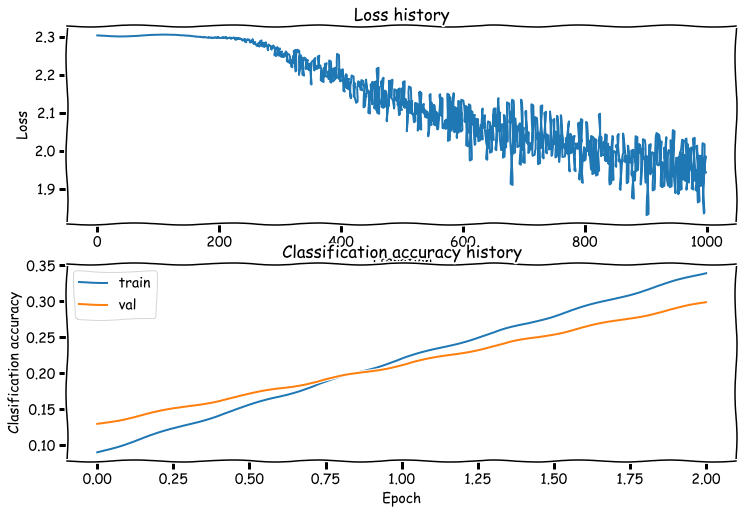

In [417]:
with plt.xkcd():
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    t_acc = plt.plot(stats['train_acc_history'], label='train')
    v_acc = plt.plot(stats['val_acc_history'], label='val')
    plt.legend()
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()

# Настройка гиперпараметров

In [434]:
best_net = {}

best_hidden = 50
best_val_acc = 0


lst_lr = [2e-3,1e-3,8e-4,5e-4]
for i_lr in lst_lr:
    net = TwoLayerNet(input_size, best_hidden, num_classes)
    stats = net.train(x_train, y_train, x_val, y_val,
                num_iters=1000, batch_size=200,
                learning_rate=i_lr, learning_rate_decay=0.95,
                reg=0.25, verbose=True)
    val_acc = (net.predict(x_val) == y_val).mean()
    print ("Learning rate: ",i_lr," Validation accuracy: ",val_acc)
    if val_acc>best_val_acc:
        best_net =  net
        best_val_acc = val_acc

iteration 0/1000: loss 2.3030
iteration 100/1000: loss 1.7769
iteration 200/1000: loss 1.6073
iteration 300/1000: loss 1.6866
iteration 400/1000: loss 1.5458
iteration 500/1000: loss 1.5209
iteration 600/1000: loss 1.5069
iteration 700/1000: loss 1.4575
iteration 800/1000: loss 1.5182
iteration 900/1000: loss 1.5109
Learning rate:  0.002  Validation accuracy:  0.4332
iteration 0/1000: loss 2.3030
iteration 100/1000: loss 1.9343
iteration 200/1000: loss 1.9207
iteration 300/1000: loss 1.7287
iteration 400/1000: loss 1.6044
iteration 500/1000: loss 1.6336
iteration 600/1000: loss 1.5617
iteration 700/1000: loss 1.4470
iteration 800/1000: loss 1.4467
iteration 900/1000: loss 1.5827
Learning rate:  0.001  Validation accuracy:  0.4736
iteration 0/1000: loss 2.3030
iteration 100/1000: loss 1.9849
iteration 200/1000: loss 1.9533
iteration 300/1000: loss 1.7428
iteration 400/1000: loss 1.6935
iteration 500/1000: loss 1.5747
iteration 600/1000: loss 1.6459
iteration 700/1000: loss 1.5554
iterat

In [343]:
lst_lr_decay = [0.95,0.9,0.85,0.8]
for i_lr_dc in lst_lr_decay:
    net = TwoLayerNet(input_size, best_hidden, num_classes)
    stats = net.train(x_train, y_train, x_val, y_val,
                num_iters=1000, batch_size=200,
                learning_rate=1e-3, learning_rate_decay=i_lr_dc,
                reg=0.25, verbose=True)
    val_acc = (net.predict(x_val) == y_val).mean()
    print ("Learning rate decay: ",i_lr_dc," Validation accuracy: ",val_acc)
    if val_acc>best_val_acc:
        best_net =  net
        best_val_acc = val_acc

iteration 0/1000: loss 2.3030
iteration 100/1000: loss 1.9282
iteration 200/1000: loss 1.8011
iteration 300/1000: loss 1.5745
iteration 400/1000: loss 1.5702
iteration 500/1000: loss 1.5721
iteration 600/1000: loss 1.6582
iteration 700/1000: loss 1.4769
iteration 800/1000: loss 1.6207
iteration 900/1000: loss 1.5200
Learning rate decay:  0.95  Validation accuracy:  0.4876
iteration 0/1000: loss 2.3030
iteration 100/1000: loss 1.9657
iteration 200/1000: loss 1.7549
iteration 300/1000: loss 1.6361
iteration 400/1000: loss 1.7545
iteration 500/1000: loss 1.5443
iteration 600/1000: loss 1.7026
iteration 700/1000: loss 1.5215
iteration 800/1000: loss 1.5248
iteration 900/1000: loss 1.5736
Learning rate decay:  0.9  Validation accuracy:  0.4676
iteration 0/1000: loss 2.3030
iteration 100/1000: loss 1.9444
iteration 200/1000: loss 1.7637
iteration 300/1000: loss 1.6324
iteration 400/1000: loss 1.6050
iteration 500/1000: loss 1.6054
iteration 600/1000: loss 1.5954
iteration 700/1000: loss 1.62

In [346]:
lst_reg = [25e-4,25e-5,25e-6]
for i_reg in lst_reg:
    net = TwoLayerNet(input_size, best_hidden, num_classes)
    stats = net.train(x_train, y_train, x_val, y_val,
                num_iters=1000, batch_size=200,
                learning_rate=1e-3, learning_rate_decay=0.95,
                reg=i_reg, verbose=True)
    val_acc = (net.predict(x_val) == y_val).mean()
    print ("Regularization: ",i_reg," Validation accuracy: ",val_acc)
    if val_acc>best_val_acc:
        best_net =  net
        best_val_acc = val_acc

iteration 0/1000: loss 2.3026
iteration 100/1000: loss 1.8934
iteration 200/1000: loss 1.7030
iteration 300/1000: loss 1.6346
iteration 400/1000: loss 1.5864
iteration 500/1000: loss 1.4738
iteration 600/1000: loss 1.4915
iteration 700/1000: loss 1.4387
iteration 800/1000: loss 1.4717
iteration 900/1000: loss 1.3064
Regularization:  0.0025  Validation accuracy:  0.4804
iteration 0/1000: loss 2.3026
iteration 100/1000: loss 1.9769
iteration 200/1000: loss 1.8416
iteration 300/1000: loss 1.6151
iteration 400/1000: loss 1.5970
iteration 500/1000: loss 1.5238
iteration 600/1000: loss 1.4316
iteration 700/1000: loss 1.5095
iteration 800/1000: loss 1.4991
iteration 900/1000: loss 1.4358
Regularization:  0.00025  Validation accuracy:  0.4572
iteration 0/1000: loss 2.3026
iteration 100/1000: loss 2.0118
iteration 200/1000: loss 1.7345
iteration 300/1000: loss 1.6680
iteration 400/1000: loss 1.6026
iteration 500/1000: loss 1.5929
iteration 600/1000: loss 1.5301
iteration 700/1000: loss 1.5635
i

In [348]:
lst_iter = [200,500,800,1000,1200,1500]
for i_iter in lst_iter:
    net = TwoLayerNet(input_size, best_hidden, num_classes)
    stats = net.train(x_train, y_train, x_val, y_val,
                num_iters=i_iter, batch_size=200,
                learning_rate=1e-3, learning_rate_decay=0.95,
                reg=25e-4, verbose=True)
    val_acc = (net.predict(x_val) == y_val).mean()
    print ("Num iterations: ",i_iter," Validation accuracy: ",val_acc)
    if val_acc>best_val_acc:
        best_net =  net
        best_val_acc = val_acc

iteration 0/200: loss 2.3026
iteration 100/200: loss 1.8711
Num iterations:  200  Validation accuracy:  0.364
iteration 0/500: loss 2.3026
iteration 100/500: loss 1.9092
iteration 200/500: loss 1.7894
iteration 300/500: loss 1.6910
iteration 400/500: loss 1.6740
Num iterations:  500  Validation accuracy:  0.4336
iteration 0/800: loss 2.3026
iteration 100/800: loss 1.8783
iteration 200/800: loss 1.7589
iteration 300/800: loss 1.6743
iteration 400/800: loss 1.5059
iteration 500/800: loss 1.6255
iteration 600/800: loss 1.5990
iteration 700/800: loss 1.5513
Num iterations:  800  Validation accuracy:  0.4652
iteration 0/1000: loss 2.3026
iteration 100/1000: loss 1.8972
iteration 200/1000: loss 1.8749
iteration 300/1000: loss 1.8008
iteration 400/1000: loss 1.7057
iteration 500/1000: loss 1.5902
iteration 600/1000: loss 1.5137
iteration 700/1000: loss 1.5803
iteration 800/1000: loss 1.4107
iteration 900/1000: loss 1.4558
Num iterations:  1000  Validation accuracy:  0.4668
iteration 0/1200: l

# Проверка качества
С оптимальными гиперпараметрами сеть должна выдавать точнов около 48%.

In [431]:
best_net = TwoLayerNet(input_size, 200, num_classes)
stats = best_net.train(x_train, y_train, x_val, y_val,
                num_iters=1000, batch_size=200,
                learning_rate=1e-3, learning_rate_decay=0.95,
                reg=25e-3, verbose=True)


val_acc = (best_net.predict(x_val) == y_val).mean()
print ("Num iterations: ",i_iter," Validation accuracy: ",val_acc)

iteration 0/1000: loss 2.3027
iteration 100/1000: loss 1.9083
iteration 200/1000: loss 1.7232
iteration 300/1000: loss 1.5959
iteration 400/1000: loss 1.4471
iteration 500/1000: loss 1.4084
iteration 600/1000: loss 1.4848
iteration 700/1000: loss 1.4027
iteration 800/1000: loss 1.4029
iteration 900/1000: loss 1.4928
Num iterations:  1500  Validation accuracy:  0.4956


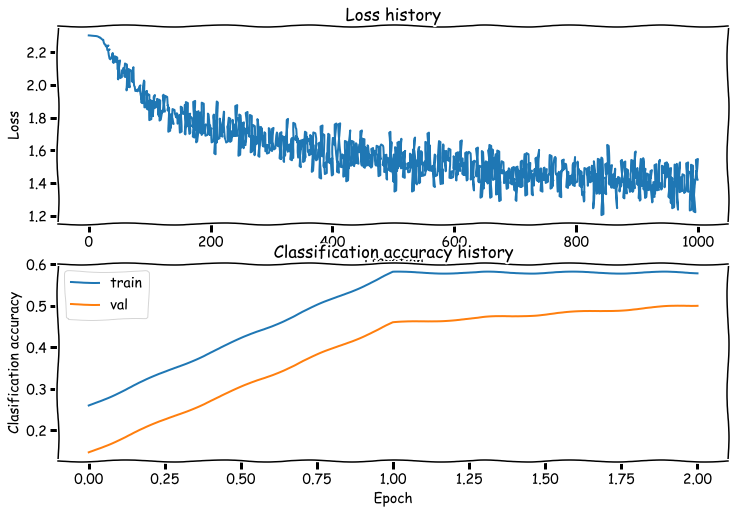

In [432]:
with plt.xkcd():
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    t_acc = plt.plot(stats['train_acc_history'], label='train')
    v_acc = plt.plot(stats['val_acc_history'], label='val')
    plt.legend()
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()

In [433]:
test_acc = (best_net.predict(x_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.4808
